In [2]:
SEQ_LEN = 20
LOAD_EXISTING = False

In [3]:
import os

import json

import pandas as pd
import numpy as np

import tensorflow as tf
from tensorflow import keras

from matplotlib import pyplot as plt
%matplotlib inline

DRIVE_FOLDER = os.path.join('drive', 'My Drive', 'neural_poet')

In [4]:
data = pd.read_csv(os.path.join(DRIVE_FOLDER, 'poems_processed.csv'))
data['poem'] = data['poem'].apply(lambda x: eval(x))
data['poem'] = data['poem'].apply(lambda x: ' | '.join(x))
data['poem'] = data['poem'].str.replace('ё', 'е')
data.sample(2)

,poem
134315,научи меня мама любить | как по нотам легко бе...
126640,в погожий летний день по вашей крыше | дождино...


In [5]:
!pip install youtokentome
import youtokentome as yttm

yttm_txt_path = os.path.join(DRIVE_FOLDER, 'poems.txt')
with open(yttm_txt_path, 'w') as f:
  for poem in data['poem'].to_numpy():
    print(poem, file=f)

yttm_model_path = os.path.join(DRIVE_FOLDER, 'yttm.model')
#yttm.BPE.train(data=yttm_txt_path, vocab_size=5000, model=yttm_model_path)

bpe = yttm.BPE(model=yttm_model_path)

test_string = 'собака съела человека | и камешком своей души | пустила облако узбека | в лесу шумели камыши'
print(bpe.encode([test_string], output_type=yttm.OutputType.ID))
print(bpe.encode([test_string], output_type=yttm.OutputType.SUBWORD))

     |████████████████████████████████| 1.7MB 14.0MB/s 
[[2117, 126, 3286, 113, 1861, 88, 94, 137, 240, 1250, 785, 574, 88, 236, 224, 113, 839, 118, 2688, 200, 126, 88, 90, 2828, 812, 240, 111, 137, 291, 184]]
[['▁соба', 'ка', '▁съе', 'ла', '▁человека', '▁|', '▁и', '▁ка', 'ме', 'шком', '▁своей', '▁души', '▁|', '▁пу', 'сти', 'ла', '▁обла', 'ко', '▁уз', 'бе', 'ка', '▁|', '▁в', '▁лесу', '▁шу', 'ме', 'ли', '▁ка', 'мы', 'ши']]


In [6]:
data['tokens'] = data['poem'].apply(bpe.encode, output_type=yttm.OutputType.ID)
data['subwords'] = data['poem'].apply(bpe.encode, output_type=yttm.OutputType.SUBWORD)

train_data = tf.keras.preprocessing.sequence.pad_sequences(data['tokens'], maxlen=300)

In [7]:
X = []
y = []

for poem in train_data:
  for i in range(len(poem)-SEQ_LEN):
    if sum(poem[i:SEQ_LEN+i]) != 0:
      X.append(poem[i:SEQ_LEN+i])
      y.append(poem[SEQ_LEN+i])

X = np.array(X)
y = np.array(y)

In [96]:
VOCAB_SIZE = bpe.vocab_size()

if not LOAD_EXISTING:
  
  input_layer = keras.layers.Input(shape=SEQ_LEN, dtype='int16')
  embeddings = keras.layers.Embedding(VOCAB_SIZE, 25)(input_layer)

  l = keras.layers.LSTM(128, stateful=False)(embeddings)
  l = keras.layers.Dense(256, activation='relu')(l)
  lstm = keras.Model(inputs=input_layer, outputs=l)

  g = keras.layers.GRU(128, stateful=False)(embeddings)
  g = keras.layers.Dense(256, activation='relu')(g)
  gru = keras.Model(inputs=input_layer, outputs=g)

  s = keras.layers.Conv1D(32, 5, padding='same', data_format='channels_first', activation='relu', input_shape=embeddings.shape[1:])(embeddings)
  s = keras.layers.BatchNormalization()(s)
  s = keras.layers.Conv1D(16, 2, padding='same', data_format='channels_first')(s)
  s = keras.layers.BatchNormalization()(s)
  s = keras.layers.Conv1D(8, 2, padding='same', data_format='channels_first')(s)
  s = keras.layers.BatchNormalization()(s)
  s = keras.layers.Flatten()(s)
  shortcut = keras.Model(inputs=input_layer, outputs=s)


  e = tf.stack([lstm.output, gru.output], axis=-1)
  e = keras.layers.BatchNormalization()(e)
  e = keras.layers.Conv1D(1, 1, padding='same', data_format='channels_last', input_shape=e.shape[1:])(e)
  e = keras.layers.BatchNormalization()(e)
  e = keras.layers.Flatten()(e)
  e = keras.layers.Dense(200, activation='relu')(e)
  encoder = keras.Model(inputs=input_layer, outputs=e)

  lm_head = keras.layers.concatenate([shortcut.output, encoder.output])
  lm_head = keras.layers.BatchNormalization()(lm_head)
  lm_head = keras.layers.Dense(1024, activation='relu')(lm_head)
  lm_head = keras.layers.Dropout(0.4)(lm_head)
  lm_head = keras.layers.Dense(200, activation='relu')(lm_head)
  lm_head = keras.layers.Dense(VOCAB_SIZE, activation=None)(lm_head)

  lstm_nlp = keras.Model(inputs=input_layer, outputs=lm_head)

  lstm_nlp.summary()

Model: "model_98"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_20 (InputLayer)           [(None, 20)]         0                                            
__________________________________________________________________________________________________
embedding_19 (Embedding)        (None, 20, 25)       125000      input_20[0][0]                   
__________________________________________________________________________________________________
lstm_19 (LSTM)                  (None, 128)          78848       embedding_19[0][0]               
__________________________________________________________________________________________________
gru_19 (GRU)                    (None, 128)          59520       embedding_19[0][0]               
___________________________________________________________________________________________

In [40]:
checkpoint_callback = tf.keras.callbacks.ModelCheckpoint(
                      os.path.join(DRIVE_FOLDER, 'lstm_nlp.h5'),
                      monitor='loss',
                      save_best_only=True,
                      verbose=1)

plateu_callback = tf.keras.callbacks.ReduceLROnPlateau(
                  monitor='loss',
                  factor=0.1,
                  patience=2,
                  verbose=1)

early_stop = tf.keras.callbacks.EarlyStopping(
                  monitor='val_accuracy',
                  patience=7,
                  restore_best_weights=True)

In [38]:
if LOAD_EXISTING:
  lstm_nlp = keras.models.load_model(os.path.join(DRIVE_FOLDER, 'lstm_nlp.h5'))

In [103]:
LR = 0.0003
EPOCHS = 200
FRACTION = 1

optimizer = tf.keras.optimizers.Adam(learning_rate=LR)
scc_loss = tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True)
lstm_nlp.compile(optimizer=optimizer, loss=scc_loss, metrics=['accuracy'])

up_to_index = int((len(X)*FRACTION)//1)
lstm_nlp.fit(X[:up_to_index], y[:up_to_index],
             epochs=EPOCHS,
             batch_size=4000,
             validation_split=0.03,
             callbacks = [checkpoint_callback, plateu_callback, early_stop])

Epoch 1/200
5831/5831 [==============================] - 230s 39ms/step - loss: 4.5965 - accuracy: 0.2405 - val_loss: 4.5328 - val_accuracy: 0.2504

Epoch 00001: loss improved from 4.61346 to 4.59708, saving model to drive/My Drive/neural_poet/lstm_nlp.h5
Epoch 2/200
5831/5831 [==============================] - 224s 38ms/step - loss: 4.5800 - accuracy: 0.2419 - val_loss: 4.5224 - val_accuracy: 0.2512

Epoch 00002: loss improved from 4.59708 to 4.58259, saving model to drive/My Drive/neural_poet/lstm_nlp.h5
Epoch 3/200
5831/5831 [==============================] - 223s 38ms/step - loss: 4.5702 - accuracy: 0.2428 - val_loss: 4.5116 - val_accuracy: 0.2522

Epoch 00003: loss improved from 4.58259 to 4.57154, saving model to drive/My Drive/neural_poet/lstm_nlp.h5
Epoch 4/200
5831/5831 [==============================] - 224s 38ms/step - loss: 4.5605 - accuracy: 0.2439 - val_loss: 4.5034 - val_accuracy: 0.2535

Epoch 00004: loss improved from 4.57154 to 4.56185, saving model to drive/My Drive/

In [86]:
def predict_on_string(my_string, max_len=60, seq_len=20, top_k=1, variant_newline=True, newline_top_k = 20, chaos_top_k=0, chaos_rate=0.5):

  s = my_string.lower().replace('ё', 'е') + ' | '
  s = bpe.encode(s, output_type=yttm.OutputType.ID)
  s = tf.keras.preprocessing.sequence.pad_sequences([s], maxlen=seq_len)
  chaos_vector = np.random.random_sample((max_len,))

  is_new_line = True
  result = []
  for i in range(max_len):

    next_token_prob_space = lstm_nlp.predict(s)
    if np.argmax(next_token_prob_space) == 88:
      next_token_sample = [88]
      is_new_line = True
    else:
      is_chaos = (chaos_vector[i] < chaos_rate) and (chaos_top_k != 0)
      if variant_newline and is_new_line and newline_top_k != 0:
        top_k_from = -(newline_top_k)
        is_new_line = False
      elif is_chaos:
        top_k_from = -(top_k + chaos_top_k)
      else:
        top_k_from = -(top_k)

      next_token_sample = np.argpartition(next_token_prob_space, top_k_from)[0][top_k_from:]

    next_token = np.random.choice(next_token_sample)
    s = np.expand_dims(np.append(s, next_token)[-seq_len:], axis=0)
    result.append(next_token)

  predicted_string = bpe.decode([result])[0]
  final_string = my_string + ' | ' + predicted_string
  final_string = final_string.replace(' | ', '\n').replace('|', '')
  return final_string

In [78]:
def poetize(raw_poem):
  lines_list = raw_poem.split('\n')
  len_list = list(map(len, lines_list))
  if (sum(len_list[:-1])/len(len_list[:-1])) > (len_list[-1] * 0.7):
    lines_list = lines_list[:-1]
  
  result = []
  for line in lines_list:
    result.append(line.capitalize())
  return '\n'.join(result)

In [109]:
neural_shit = predict_on_string('что значил этот сон',
                                top_k=2,
                                chaos_top_k=45,
                                chaos_rate=0.25,
                                variant_newline=True,
                                newline_top_k=120)
print(poetize(neural_shit))

Что значил этот сон
Тот кто любит и нет
Где же сердце болит
Там всегда и везде
Время в душе живет
От любви и тепла
Лучше ее уже
Коль в душе пустота
Жизнь моя не одна
Со мною рядом одна
Может ты не грустишь
Это все что было


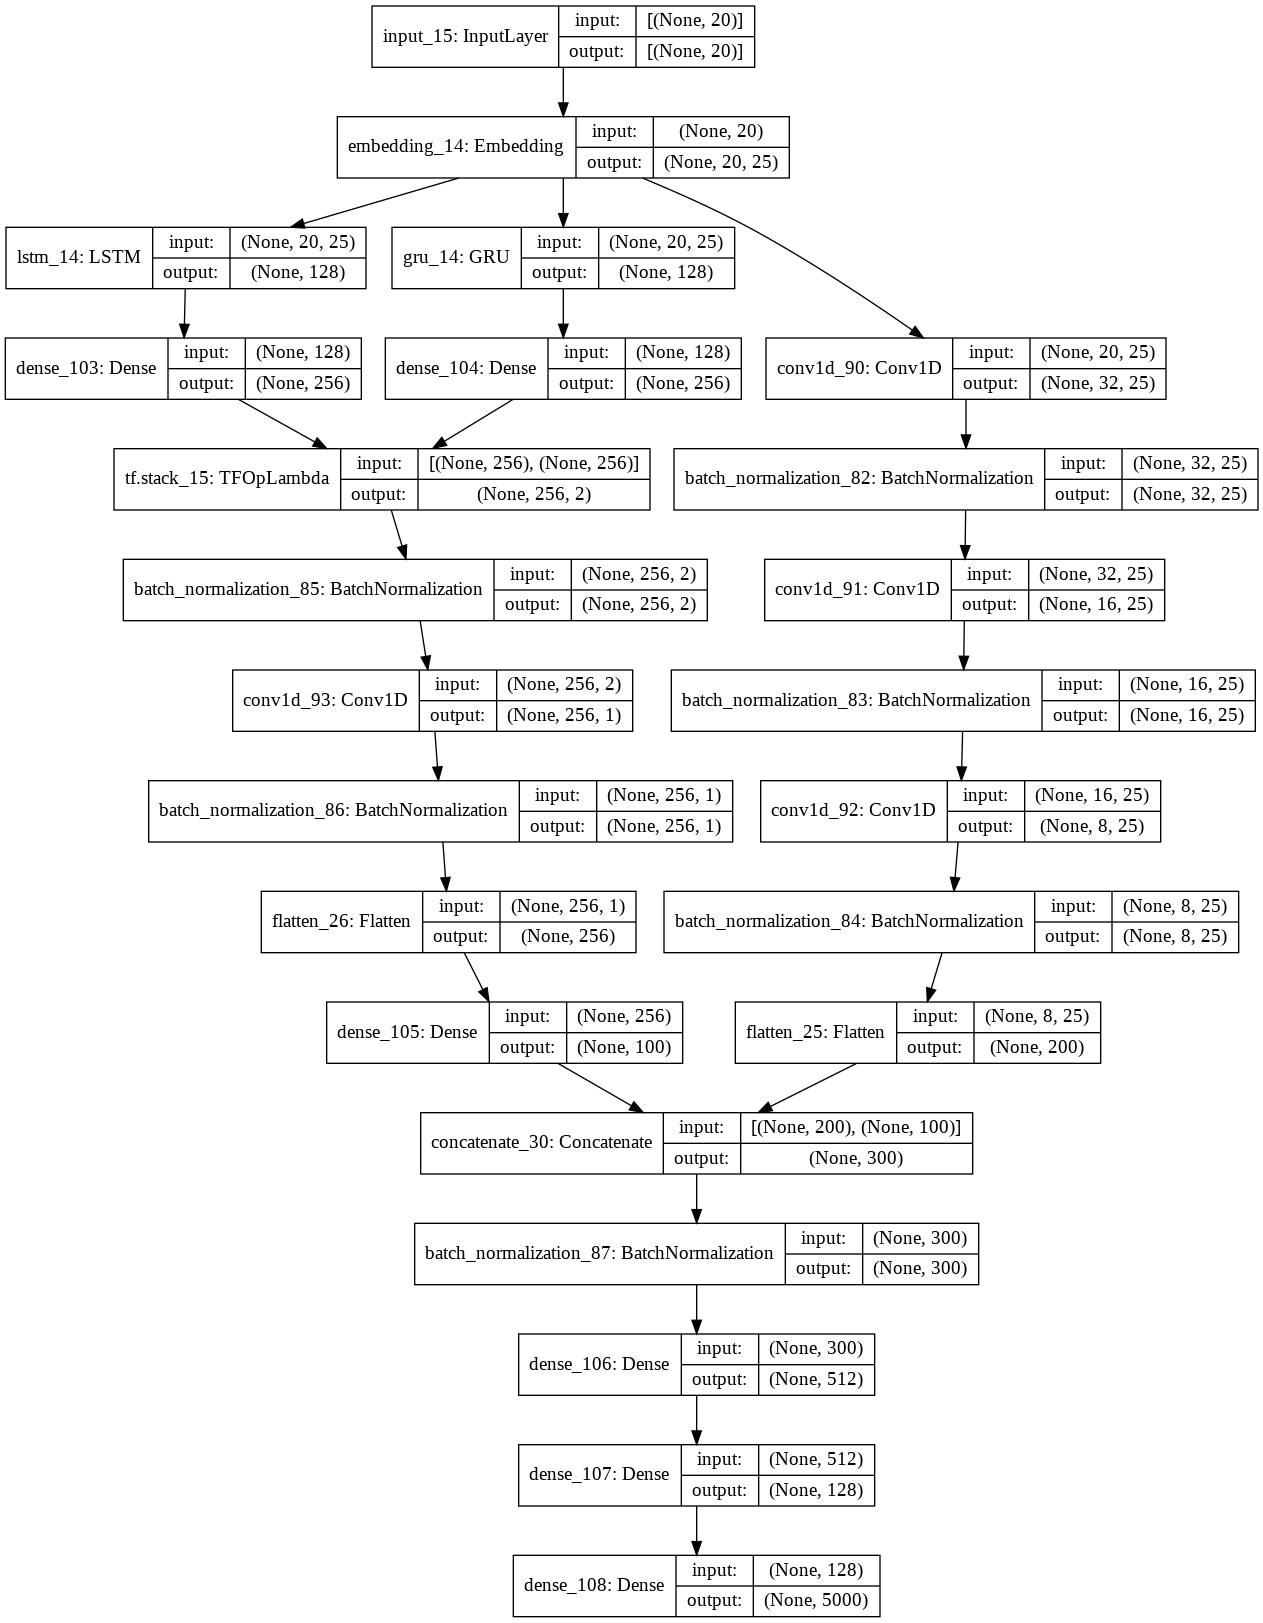

In [91]:
tf.keras.utils.plot_model(lstm_nlp, show_shapes=True)

In [104]:
tf.saved_model.save(lstm_nlp, os.path.join(DRIVE_FOLDER, 'full_nlp_model'))

INFO:tensorflow:Assets written to: drive/My Drive/neural_poet/full_nlp_model/assets


INFO:tensorflow:Assets written to: drive/My Drive/neural_poet/full_nlp_model/assets
